# Deep Convloutional GAN (DCGAN)

- Referecnce : https://github.com/eriklindernoren/PyTorch-GAN

In [1]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Use MNIST Dataset & DataLoader

In [3]:
bs =128

dataset = datasets.MNIST("./mnist", train=True, download=True, 
                         transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=True)

torch.Size([128, 1, 32, 32]) tensor([9, 6, 4, 8, 6, 9, 2, 2, 3, 8, 3, 7, 8, 9, 0, 6, 8, 1, 7, 7, 6, 1, 3, 9,
        4, 8, 8, 2, 7, 5, 3, 6, 8, 3, 9, 2, 2, 7, 2, 7, 9, 2, 5, 6, 9, 0, 6, 5,
        7, 8, 3, 5, 7, 0, 0, 5, 5, 4, 6, 0, 6, 8, 5, 8, 0, 3, 0, 7, 3, 5, 2, 3,
        3, 6, 0, 1, 1, 2, 2, 2, 1, 3, 0, 3, 2, 2, 8, 3, 2, 5, 5, 6, 1, 9, 5, 4,
        6, 0, 1, 3, 9, 5, 8, 2, 2, 6, 6, 2, 5, 3, 5, 5, 3, 6, 0, 3, 1, 9, 0, 1,
        1, 1, 0, 8, 9, 3, 1, 6])


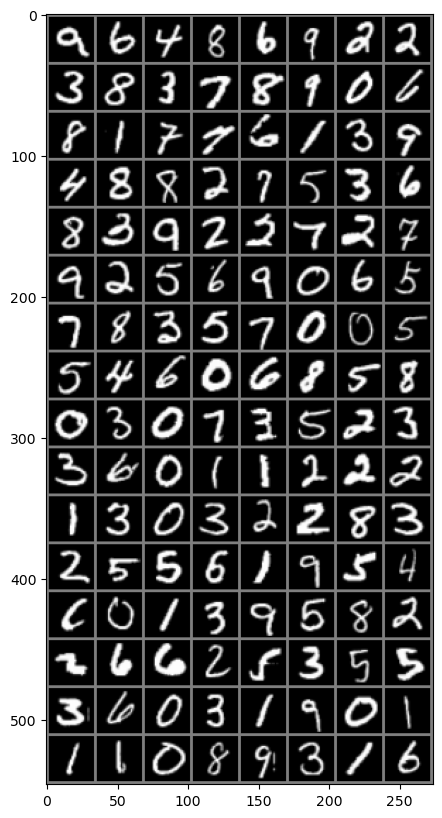

In [4]:
batch = next(iter(dataloader))
len(batch)
print(batch[0].shape, batch[1])

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
imshow(torchvision.utils.make_grid(batch[0]))

## Define Generator & Discriminator
### Generator architecture
input random vector: 100 dim
* Linear: out_features 128 * 8 * 8
* BatchNorm2d
* Upsample: scale_factor 2
* Conv2d: out_channel: 128, kernel size 3, stride 1, padding 1
* BatchNorm2d
* LeakyReLU: 0.2
* Upsample: scale_factor 2
* Conv2d: out_channel: 64, kernel size 3, stride 1, padding 1
* BatchNorm
* LeakyReLU: 0.2
* Conv2d: out_channel: 1, kernel size 3, stride 1, padding 1
* Tanh

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        # self.fc1 = 
        # self.bn1 = 
        # self.us = 
        # self.conv1 = 
        # self.bn2 = 
        # self.act = 
        # self.conv2 = 
        # self.bn3 = 
        # self.conv3 = 
        # self.last_act =
        self.fc1 = nn.Linear(100, 128*8*8)
        self.bn1 = nn.BatchNorm2d(128)
        self.up = nn.Upsample(scale_factor=2)
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(128, 128, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 1, 3, 1, 1)
        self.last_act = nn.Tanh()


    def forward(self, z):
        #### Implement Here ####
        #### Hint : z should be reshaped into 2d before going into bn layer
        z = self.fc1(z)
        img = z.view(-1, 128, 8, 8)
        img = self.bn1(img)
        img = self.act(self.bn2(self.conv1(self.up(img))))
        img = self.act(self.bn3(self.conv2(self.up(img))))
        img = self.last_act(self.conv3(img))

        return img

### Discriminator architecture
input: [1 , 32 , 32] image 
* Conv2d: out_channel: 16, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* Conv2d: out_channel: 32, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Conv2d: out_channel: 64, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Conv2d: out_channel: 128, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Linear: out_features 1
* Sigmoid

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        self.block1 = self.make_block(1, 16, False)
        self.block2 = self.make_block(16, 32)
        self.block3 = self.make_block(32, 64)
        self.block4 = self.make_block(64, 128)
        self.fc = nn.Linear(512, 1)
        self.last_act = nn.Sigmoid()


    def make_block(self, in_channel, out_channel, bn= True):
        #### Implement Here ####
        layers = [
            nn.Conv2d(in_channel, out_channel, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
        ]
        if bn:
            # layers.append(?)
            layers.append(nn.BatchNorm2d(out_channel))
        
        return nn.Sequential(*layers) 
        
        
    def forward(self, img):# [1, 32, 32]
        #### Implement Here ####
        img = self.block1(img)
        img = self.block2(img)
        img = self.block3(img)
        img = self.block4(img)
        x = img.view(-1,128*2*2)
        x = self.last_act(self.fc(x))

        return x


In [17]:
# Initialize generator and discriminator
G = Generator()
D = Discriminator()

In [18]:
from torchsummary import summary
summary(G, device = 'cpu', batch_size = -1, input_size = (100,))
summary(D, device = 'cpu', batch_size = -1, input_size = (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]         827,392
       BatchNorm2d-2            [-1, 128, 8, 8]             256
          Upsample-3          [-1, 128, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]         147,584
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
          Upsample-7          [-1, 128, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          73,792
       BatchNorm2d-9           [-1, 64, 32, 32]             128
        LeakyReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11            [-1, 1, 32, 32]             577
             Tanh-12            [-1, 1, 32, 32]               0
Total params: 1,049,985
Trainable params: 1,049,985
Non-trainable params: 0
---------------------------

## Weight Initialization

In [19]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1: # Conv2d layer weights init
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1: # BatchNorm2d layer weights init
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# weight initialize
G.apply(weights_init_normal)
D.apply(weights_init_normal)

Discriminator(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

## Define loss & Optimizer & model

* loss : BCELoss
* optimizer (for both G, D) : Adam with {lr=0.0002, betas=(0.5, 0.9999)} 

In [20]:
#### Implement Here ####
# Loss function
criterion = torch.nn.BCELoss()



# Optimizer
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.9999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.9999))

## Start Training

In [21]:
G, D = G.to(device), D.to(device)
os.makedirs("./dcgan_images", exist_ok=True)
epochs = 20

[Epoch 0/20] [Batch 0/468] [D loss: 0.755584] [G loss: 0.806754]


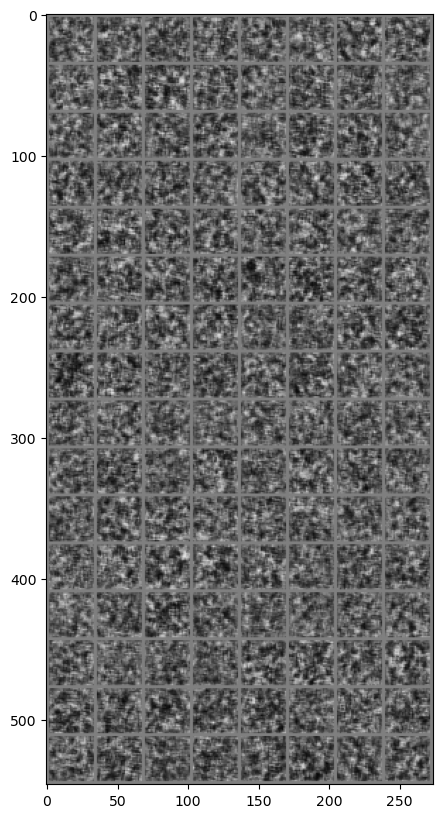

[Epoch 0/20] [Batch 100/468] [D loss: 0.702111] [G loss: 0.785353]
[Epoch 0/20] [Batch 200/468] [D loss: 0.709499] [G loss: 0.683676]
[Epoch 0/20] [Batch 300/468] [D loss: 0.725931] [G loss: 0.717806]
[Epoch 0/20] [Batch 400/468] [D loss: 0.709413] [G loss: 0.698030]
[Epoch 1/20] [Batch 32/468] [D loss: 0.674123] [G loss: 0.683438]
[Epoch 1/20] [Batch 132/468] [D loss: 0.695594] [G loss: 0.694388]
[Epoch 1/20] [Batch 232/468] [D loss: 0.639308] [G loss: 0.776664]
[Epoch 1/20] [Batch 332/468] [D loss: 0.601404] [G loss: 0.807254]
[Epoch 1/20] [Batch 432/468] [D loss: 0.654091] [G loss: 0.745865]
[Epoch 2/20] [Batch 64/468] [D loss: 0.641614] [G loss: 0.812560]
[Epoch 2/20] [Batch 164/468] [D loss: 0.629295] [G loss: 0.875133]
[Epoch 2/20] [Batch 264/468] [D loss: 0.508292] [G loss: 0.990650]
[Epoch 2/20] [Batch 364/468] [D loss: 0.531209] [G loss: 1.368281]
[Epoch 2/20] [Batch 464/468] [D loss: 0.494426] [G loss: 1.019085]
[Epoch 3/20] [Batch 96/468] [D loss: 0.435007] [G loss: 1.300268

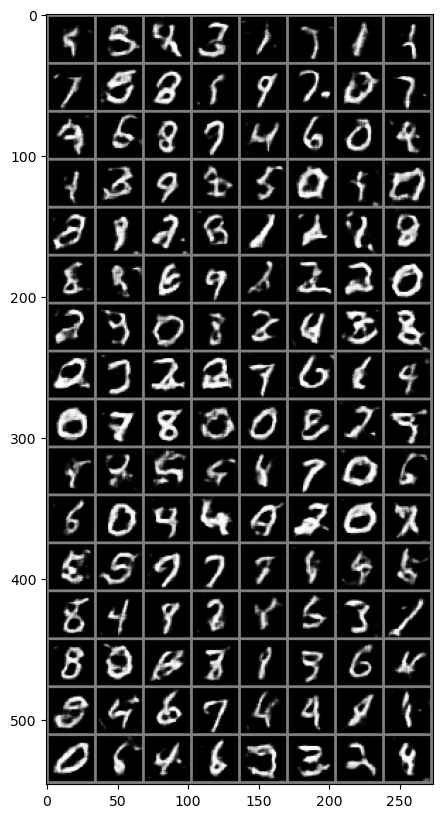

[Epoch 4/20] [Batch 228/468] [D loss: 0.551144] [G loss: 0.951696]
[Epoch 4/20] [Batch 328/468] [D loss: 0.297725] [G loss: 1.016592]
[Epoch 4/20] [Batch 428/468] [D loss: 0.350817] [G loss: 1.904115]
[Epoch 5/20] [Batch 60/468] [D loss: 0.278683] [G loss: 1.206333]
[Epoch 5/20] [Batch 160/468] [D loss: 0.399875] [G loss: 0.836464]
[Epoch 5/20] [Batch 260/468] [D loss: 0.317310] [G loss: 1.710061]
[Epoch 5/20] [Batch 360/468] [D loss: 0.363611] [G loss: 1.347443]
[Epoch 5/20] [Batch 460/468] [D loss: 0.394620] [G loss: 2.316770]
[Epoch 6/20] [Batch 92/468] [D loss: 0.423955] [G loss: 0.928658]
[Epoch 6/20] [Batch 192/468] [D loss: 0.365800] [G loss: 1.470232]
[Epoch 6/20] [Batch 292/468] [D loss: 0.247390] [G loss: 1.814793]
[Epoch 6/20] [Batch 392/468] [D loss: 0.366997] [G loss: 2.451041]
[Epoch 7/20] [Batch 24/468] [D loss: 0.175929] [G loss: 1.834352]
[Epoch 7/20] [Batch 124/468] [D loss: 0.349425] [G loss: 2.312842]
[Epoch 7/20] [Batch 224/468] [D loss: 0.417335] [G loss: 1.669362

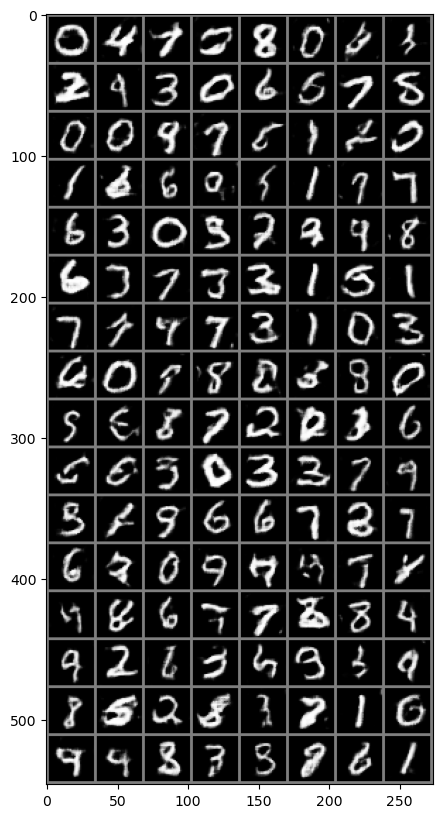

[Epoch 8/20] [Batch 356/468] [D loss: 0.181803] [G loss: 2.209131]
[Epoch 8/20] [Batch 456/468] [D loss: 0.342662] [G loss: 2.834646]
[Epoch 9/20] [Batch 88/468] [D loss: 0.172001] [G loss: 3.056181]
[Epoch 9/20] [Batch 188/468] [D loss: 0.197261] [G loss: 1.558502]
[Epoch 9/20] [Batch 288/468] [D loss: 0.148375] [G loss: 2.280766]
[Epoch 9/20] [Batch 388/468] [D loss: 0.208842] [G loss: 1.491390]
[Epoch 10/20] [Batch 20/468] [D loss: 0.235563] [G loss: 1.726148]
[Epoch 10/20] [Batch 120/468] [D loss: 0.153625] [G loss: 3.783196]
[Epoch 10/20] [Batch 220/468] [D loss: 0.111117] [G loss: 2.656698]
[Epoch 10/20] [Batch 320/468] [D loss: 0.078559] [G loss: 2.357574]
[Epoch 10/20] [Batch 420/468] [D loss: 0.137070] [G loss: 4.041601]
[Epoch 11/20] [Batch 52/468] [D loss: 0.395927] [G loss: 1.752270]
[Epoch 11/20] [Batch 152/468] [D loss: 0.212179] [G loss: 2.609433]
[Epoch 11/20] [Batch 252/468] [D loss: 0.208312] [G loss: 2.498379]
[Epoch 11/20] [Batch 352/468] [D loss: 0.179770] [G loss:

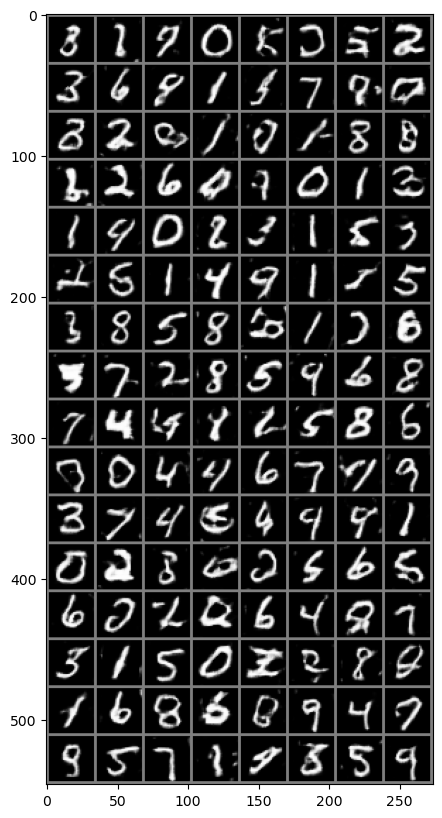

[Epoch 13/20] [Batch 16/468] [D loss: 0.061335] [G loss: 2.739185]
[Epoch 13/20] [Batch 116/468] [D loss: 0.381052] [G loss: 0.960867]
[Epoch 13/20] [Batch 216/468] [D loss: 0.075383] [G loss: 2.456101]
[Epoch 13/20] [Batch 316/468] [D loss: 0.201391] [G loss: 2.805034]
[Epoch 13/20] [Batch 416/468] [D loss: 0.105626] [G loss: 3.497183]
[Epoch 14/20] [Batch 48/468] [D loss: 0.123884] [G loss: 4.187404]
[Epoch 14/20] [Batch 148/468] [D loss: 0.117091] [G loss: 2.760607]
[Epoch 14/20] [Batch 248/468] [D loss: 0.236885] [G loss: 0.489049]
[Epoch 14/20] [Batch 348/468] [D loss: 0.162548] [G loss: 1.321060]
[Epoch 14/20] [Batch 448/468] [D loss: 0.122034] [G loss: 2.466267]
[Epoch 15/20] [Batch 80/468] [D loss: 0.100563] [G loss: 2.166136]
[Epoch 15/20] [Batch 180/468] [D loss: 0.313862] [G loss: 5.609338]
[Epoch 15/20] [Batch 280/468] [D loss: 0.278811] [G loss: 4.029483]
[Epoch 15/20] [Batch 380/468] [D loss: 0.127521] [G loss: 3.695820]
[Epoch 16/20] [Batch 12/468] [D loss: 0.063567] [G 

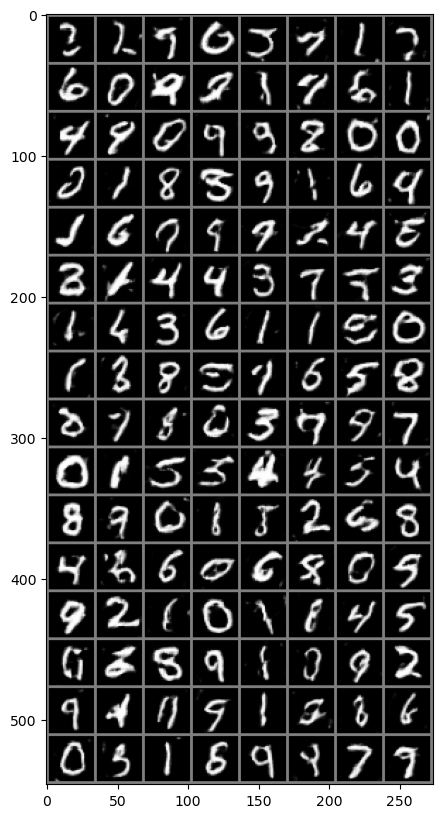

[Epoch 17/20] [Batch 144/468] [D loss: 0.038761] [G loss: 3.928136]
[Epoch 17/20] [Batch 244/468] [D loss: 0.117518] [G loss: 5.062980]
[Epoch 17/20] [Batch 344/468] [D loss: 0.092417] [G loss: 2.409117]
[Epoch 17/20] [Batch 444/468] [D loss: 0.043369] [G loss: 3.574529]
[Epoch 18/20] [Batch 76/468] [D loss: 0.162315] [G loss: 4.172658]
[Epoch 18/20] [Batch 176/468] [D loss: 0.060628] [G loss: 2.104447]
[Epoch 18/20] [Batch 276/468] [D loss: 0.170999] [G loss: 2.001735]
[Epoch 18/20] [Batch 376/468] [D loss: 0.143660] [G loss: 1.854059]
[Epoch 19/20] [Batch 8/468] [D loss: 0.077760] [G loss: 3.148103]
[Epoch 19/20] [Batch 108/468] [D loss: 0.021693] [G loss: 3.421627]
[Epoch 19/20] [Batch 208/468] [D loss: 0.152594] [G loss: 3.293818]
[Epoch 19/20] [Batch 308/468] [D loss: 0.061653] [G loss: 3.743032]
[Epoch 19/20] [Batch 408/468] [D loss: 0.088186] [G loss: 4.523313]


In [22]:
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):

        real_imgs = real_imgs.to(device)

        # Sample noise as generator input
        z = torch.Tensor(np.random.normal(0, 1, (real_imgs.shape[0], 100))).to(device)

        # -----------------
        #  Train Generator
        # -----------------
        #### Implement Here ####
        gen_imgs = G(z)
        ones = torch.ones((gen_imgs.size(0), 1)).to(device)
        zeros = torch.zeros((gen_imgs.size(0), 1)).to(device)
        
        optimizer_G.zero_grad()
        g_loss = criterion(D(gen_imgs), ones)
        g_loss.backward()
        optimizer_G.step()
        
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        #### Implement Here ####
        optimizer_D.zero_grad()
        fake_loss = criterion(D(gen_imgs.detach()), zeros)
        real_loss = criterion(D(real_imgs), ones)
        d_loss = (fake_loss + real_loss)/2
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        
        
        
        batches_done = epoch * len(dataloader) + i

        if batches_done % 100 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        if batches_done % 2000 == 0:
            save_image(gen_imgs.data, "dcgan_images/%06d.png" % batches_done, nrow=8, normalize=True)
            imshow(torchvision.utils.make_grid(gen_imgs.cpu()))

## Inference
- Check noise space

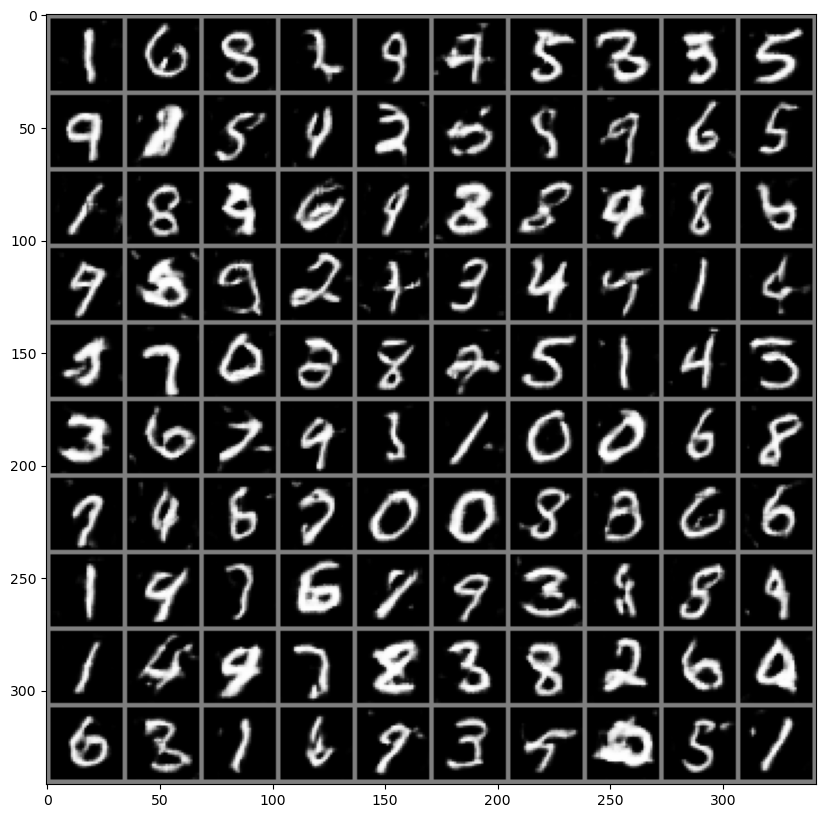

In [23]:
G.eval()
D.eval()

# 랜덤 노이즈(noise) 샘플링
z = torch.normal(mean=0, std=1, size=(100, 100)).to(device)

# 이미지 생성
gen_img = G(z)

imshow(torchvision.utils.make_grid(gen_img.detach().cpu(), nrow=10))

### Vector arithmetic 
- Pick three samples of cluster and take mean

In [24]:
ones = (z[17].unsqueeze(0) + z[20].unsqueeze(0) + z[81].unsqueeze(0)) / 3
sevens = (z[0].unsqueeze(0) + z[10].unsqueeze(0) + z[12].unsqueeze(0)) / 3
nines = (z[22].unsqueeze(0) + z[20].unsqueeze(0) + z[97].unsqueeze(0)) / 3

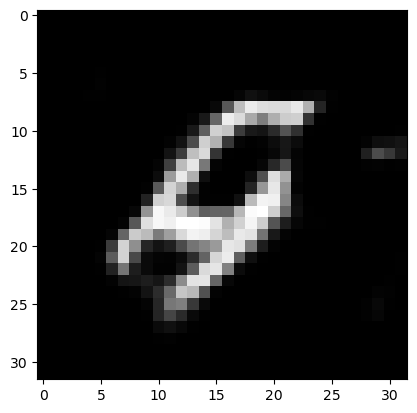

In [25]:
# ones
gen_img = G(ones).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

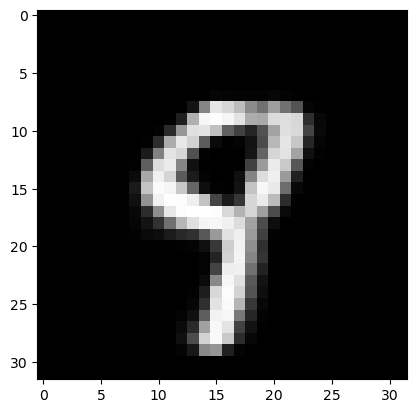

In [26]:
# sevens
gen_img = G(sevens).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

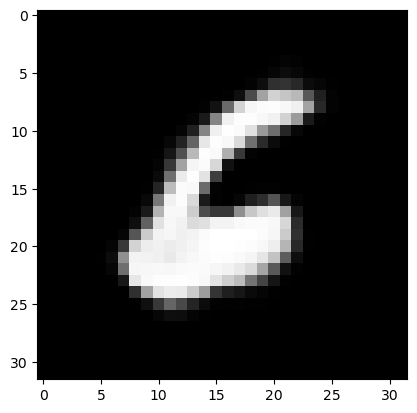

In [27]:
# twos
gen_img = G(nines).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

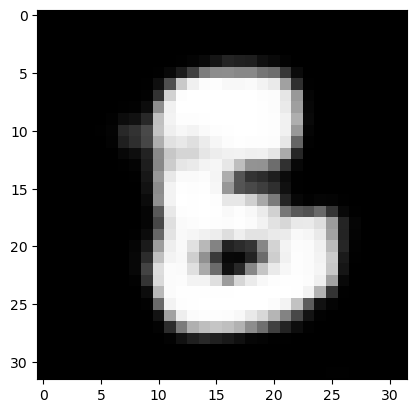

In [28]:
# vector_arithmetic
gen_vec = - ones + nines
gen_img = G(gen_vec).detach().cpu()
plt.imshow(gen_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

### Noise Interpolation Visualize
- interpolate noise vector and visualize

torch.Size([10, 1, 32, 32])


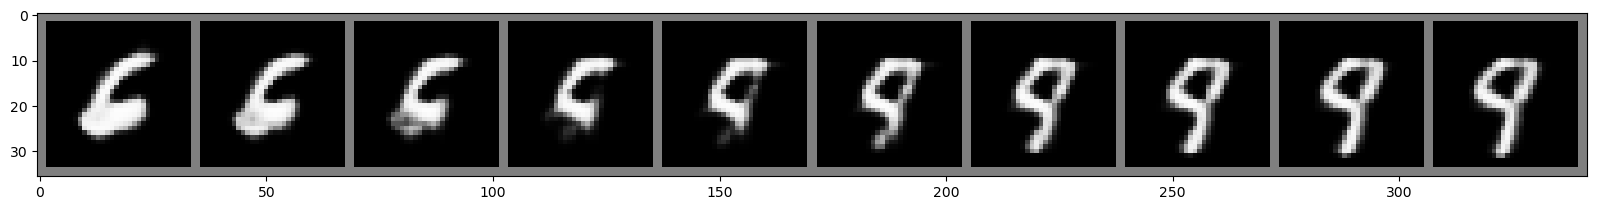

In [29]:
num_inter = 10
current = torch.Tensor(size=(num_inter, 100)).to(device)
for i in range(num_inter):
    current[i] = (sevens.squeeze(0) * (i / (num_inter-1)) + nines.squeeze(0) * (((num_inter-1) - i) / (num_inter-1)))

gen_img = G(current).detach().cpu()
print(gen_img.shape)
imshow(torchvision.utils.make_grid(gen_img, nrow=num_inter))